# The three ingredients of a classifier: the model, the loss, and the optimizer

We will use extensively numpy, pandas, and matplotlib libraries over the lectures.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Let's build a simple dataset

We will first take a subset of data of the iris dataset. It will simplify and allow to come with some intuitions. We will select the sepal length and width.

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

In [3]:
X = X[:, :2]

In addition, we will use only the samples corresponding to the class `0` and `1`.

In [4]:
mask_class_0_1 = np.bitwise_or(y == 0, y == 1)

In [5]:
X = X[mask_class_0_1]
y = y[mask_class_0_1]

We can make a scatter of those data.

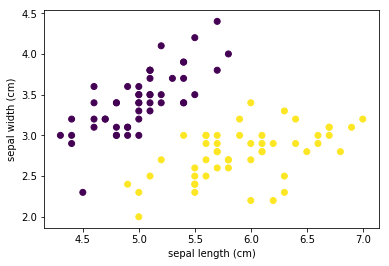

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);

## 2. The model: case of a linear classifier

A classifier can be seen as a function $f(\cdot)$ such that given $\mathbf{x}$ (i.e., a row of the matrix `X`) will return $y$ (i.e., the class of the flower). So basically, we have $f(\mathbf{x}) = y$.

When we deal with a linear classifier, it means that the function $f(\mathbf{x})$ is a linear combination of the input features (i.e., sepal width adn sepal length). Therefore, we can formulate this as $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x}$. Sometimes, an extra parameter is included avoiding the function to pass by the origin: the bias. The function is then represented by $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$

Intuitevely, in our previous example it means that $f(\mathbf{X}) = 0$ is the line which separate the data into two classes.

### Questions

* Define a pair of points which separate the two classes. Plot a line joining these points.

In [7]:
decision_points = np.array(
    [[4.0, 2.0],
     [7.2, 4.5]]
)

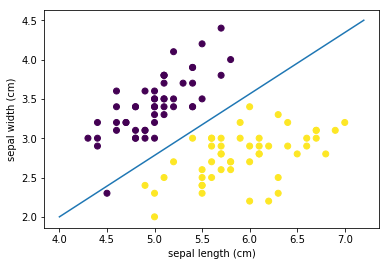

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plt.plot(decision_points[:, 0], decision_points[:, 1]);

We recall that a linear classifier is defined the function $f(\mathbf{X}) = \mathbf{w} \cdot \mathbf{X} + b$

* From the pair of points that you defined previously, how do you compute the associated weight with the decsion function defined by the pair of points? Hint: You can look at `numpy.linalg.solve`.

In [9]:
coefs = np.linalg.solve(decision_points,
                        np.ones(shape=(decision_points.shape[0], 1)))
coefs

array([[ 0.69444444],
       [-0.88888889]])

We could also inverse the function to find $\mathbf{w}$ such that $\mathbf{w} = \mathbf{X}^{-1} \cdot \mathbf{b}$

In [10]:
coefs = np.dot(np.linalg.inv(decision_points),
               np.ones(shape=(decision_points.shape[0], 1)))
coefs

array([[ 0.69444444],
       [-0.88888889]])

* Using the coefficients that you computed, define a function which would compute the distance to the line. Hint: this is basically the function of a linear classifier.

In [11]:
def decision_function(X, coefs, intercept):
    return np.dot(X, coefs) + intercept

* Take the first sample of the dataset and compute the distance to the line. Check also the sign which will let you know on which side of the line the point will lie.

In [12]:
sample = X[0]
decision_function(sample, coefs, -1)

array([-0.56944444])

Therefore, knowing these coefficient we can actually create a linear classifier which can automatically tell us on which side of the line we are.

In [13]:
class ManualLinearClassifier:
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()

So now we can create a classifier and call the appropriate function to compute the distance to the line.

In [14]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)

In [15]:
clf.decision_function(np.array([[5.0, 2.0]]))

array([0.69444444])

We can plot the line corresponding to $\mathbf{w} \cdot \mathbf{X} + b = 0$ which should be our line.

In [16]:
def plot_2d_separator(classifier, X, ax=None, levels=None, eps=None):
    eps = X.std() / 2. if eps is None else eps
    levels = [0] if levels is None else levels
    ax = plt.gca() if ax is None else ax
    
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.decision_function(X_grid)
    CS = ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels)
    ax.clabel(CS, inline=1, fontsize=10)

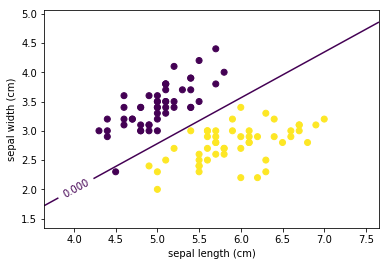

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=[0])

We can also plot different distance ranging from -5 to 5.

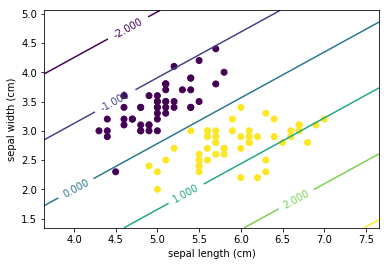

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))

### Questions

* Modify the previous classifier class to add a `predict_proba` function. This function should apply a sigmoid function on the output of the `decision_function` to output probabilities. Beaware that we expect the probablity to belong to the class 0 and to the class 1.

In [19]:
class ManualLinearClassifier:
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()

    @staticmethod
    def _sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def predict_proba(self, X):
        prob = self._sigmoid(self.decision_function(X))
        return np.vstack((1 - prob, prob)).T

In [20]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)

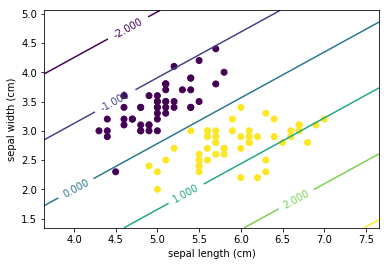

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))

In [22]:
print('Decision function: ',
      clf.decision_function(np.array([[5.0, 2.0]])))
print('Probability: ',
      clf.predict_proba(np.array([[5.0, 2.0]])))

Decision function:  [0.69444444]
Probability:  [[0.33304511 0.66695489]]


* Implement a `predict` method which should threshold the probability and output only the correct label. You can use the sign of the `decision_function` for instance.

In [23]:
class ManualLinearClassifier:
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()

    @staticmethod
    def _sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def predict_proba(self, X):
        prob = self._sigmoid(self.decision_function(X))
        return np.vstack((1 - prob, prob)).T
    
    def predict(self, X):
        dist = np.sign(self.decision_function(X))
        dist[dist < 0] = 0
        return dist.astype(int)

In [24]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)

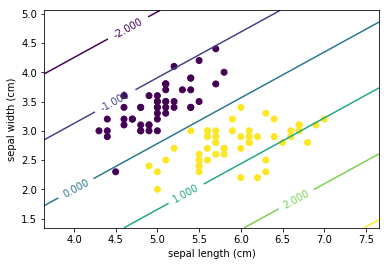

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))

In [26]:
print('Decision function: ',
      clf.decision_function(np.array([[5.0, 2.0]])))
print('Probability: ',
      clf.predict_proba(np.array([[5.0, 2.0]])))
print('Label: ',
      clf.predict(np.array([[5.0, 2.0]])))

Decision function:  [0.69444444]
Probability:  [[0.33304511 0.66695489]]
Label:  [1]


* Compute the accuracy of our classifier on the whole dataset. You can import the function `sklearn.metrics.accuracy_score`.

In [27]:
from sklearn.metrics import accuracy_score
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)
print('The mean accuracy is: ', accuracy_score(y, clf.predict(X)))

The mean accuracy is:  0.99


## 3. The duo loss-optimizer

Up to now, we create a classifier and define the "decision rule" by hand. However, machine learning provides algorithms and tools to learn these decision rules directly from the data. Indeed, this learning problem can be formulated as an optimization problem: we use an optimizer to find the best set of parameters of our model which reduce a cost function. 

#### 3.1 Our loss function: negative log likelihood

For a classificatiion problem, we can use the maximum likelihood principle. Indeed, we are interested in maximizing the following:

$\mathbf{\hat{w}} = \underset{\mathbf{w}}{\text{argmax}} P(\mathbf{Y} | \mathbf{X}; \mathbf{w})\ .$

In plain English, we are interested in finding the parameters which give rise to our data. Under some assumptions, the maximum likelihood estimate is equal to:

$\mathbf{\hat{w}} = \underset{\mathbf{w}}{\text{argmax}} \prod_{i=1}^{m} P(\mathbf{y}_{i} | \mathbf{x}_{i}; \mathbf{w})\ .$

However, the product is not convenient and we can replace by a sum by taking the log of the maximum likelihood:

$\mathbf{\hat{w}} = \underset{\mathbf{w}}{\text{argmax}} \sum_{i=1}^{m} \log P(\mathbf{y}_{i} | \mathbf{x}_{i}; \mathbf{w})\ .$

Therefore, maximizing the log likelihood is equivalent to minimizing the negative log likelihood.

Knowing that for the logistic regression, we have $P(\mathbf{y}_{i} | \mathbf{x}_{i}; \mathbf{w}) = (\sigma(\mathbf{x}_{i}))^{\mathbf{y}_{i}} (1 - \sigma(\mathbf{x}_{i}))^{1 - \mathbf{y}_{i}}$. $\sigma(\cdot)$ is the sigmoid function.

Thus, our the negative log likelihood is defined as:

$l(\mathbf{w}) = - \sum_{i=1}^{m} \mathbf{y}_{i} \log \sigma(\mathbf{x}_{i}) + (1 - \mathbf{y}_{i}) \log (1 - \sigma(\mathbf{x}_{i}))$

This metric is implemented in `sklearn.metrics.log_loss`

#### 3.2 Our optimizer: stochastic gradient descent

To minimize a given function, one can use the gradient descent algorithm. For our problem, we want to iteratively update our set of our model parameters such that the function $l(\mathbf{w})$ is decreasing. An update in the gradient descent is formulated as:

$\mathbf{w} := \mathbf{w} - \frac{\alpha}{m} \Delta_{\mathbf{w}}l \ ,$

where $\alpha$ is the learning rate and $m$ is the number of samples used for computed the derivative of the loss. The derivative of the negative log likelihood is defined as:

$\Delta_{\mathbf{w}}l = \mathbf{x}^{T} \cdot (\sigma(\mathbf{x}) - \mathbf{y}) \ .$

Stochastic gradient descent differs from a gradient descent by selecting a mini-batch of samples to make an update.

### Questions

* Create a function called `grad_nll` which given `X`, `y`, an `coefs` compute the derivative of the log likelihood as defined above.

In [28]:
def grad_nll(X, y, coefs):
    y_pred = np.dot(X, coefs)
    y_pred = 1 / (1 + np.exp(-y_pred))
    grad = (y_pred - y)
    return np.dot(X.T, grad)

* Create a function called `sgd_train`. Pass `X`, `y`, `batch_size`, `max_iter`, and `learning_rate` as parameter.
* Initialize the weight with random values. The size is defined by the number of features in `X`.
* In an infinite loop, do:
    * Select a subset of data defined by a variable `batch_size`,
    * Compute the gradient of the negative log likelihood using the above function.
    * increase the number of iteration
* Stop iterating after `max_iter`.

In [29]:
def sgd_train(X, y, batch_size, max_iter, learning_rate):
    X = np.hstack((X, np.ones(shape=(X.shape[0], 1))))
    y = np.atleast_2d(y).T
    # Initialize randomly the weights
    coefs = np.random.rand(X.shape[1], 1)

    it = 0
    while it < max_iter:
        # select a minibatch
        idx = np.random.choice(np.arange(X.shape[0]),
                               size=batch_size)
        X_subset, y_subset = X[idx], y[idx]
        # compute the gradient
        dnll = grad_nll(X_subset, y_subset, coefs)
        # update the parameter
        coefs -= (learning_rate / X_subset.shape[0]) * dnll
        it += 1
    return coefs

Now, we will check if your optimization is working. Let's compute the coefficients using the `sgd_train` function.

In [30]:
coefs = sgd_train(X, y, batch_size=20, max_iter=1000, learning_rate=0.1)

We will reuse our old classifier and set the coefficients an instance.

In [31]:
clf = ManualLinearClassifier(decision_points)

In [32]:
clf.coefs_ = coefs[:2]
clf.intercept_ = coefs[2]

We can finally check what decision boundaries did we learn with our logistic regression classifier.

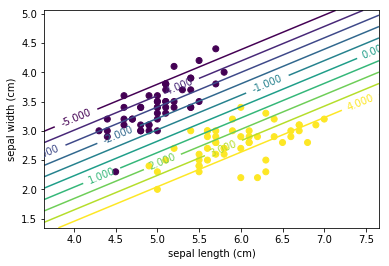

In [33]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))

### 4. Our final classifier

In [34]:
from sklearn.metrics import log_loss


class LogisticRegression:
    
    def __init__(self, learning_rate=0.1, max_iter=100, tol=1e-3,
                 batch_size=20):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.batch_size = batch_size
    
    def _sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def _decision_function(self, X):
        return np.dot(X, self.coefs_)
    
    def decision_function(self, X):
        X = self._add_intercept(X)
        return self._decision_function(X).ravel()
    
    def _grad_nll(self, X, y):
        grad = (self._predict_proba(X) - y)
        return np.dot(X.T, grad)
    
    def _add_intercept(self, X):
        return np.hstack((X, np.ones(shape=(X.shape[0], 1))))

    def fit(self, X, y):
        X = self._add_intercept(X)
        # Make y to be a column vector for later operation
        y = np.atleast_2d(y).T
        # Initialize randomly the weights
        self.coefs_ = np.random.rand(X.shape[1], 1)
        
        it = 0
        loss = np.inf
        while it < self.max_iter and loss > self.tol:
            # select a minibatch
            idx = np.random.choice(np.arange(X.shape[0]),
                                   size=self.batch_size)
            X_subset, y_subset = X[idx], y[idx]
            # compute the gradient
            dnll = self._grad_nll(X_subset, y_subset)
            # update the parameter
            self.coefs_ -= (self.learning_rate / X_subset.shape[0]) * dnll
            # update the loss and the number of iteration
            loss = log_loss(y, self._predict_proba(X))
            it += 1
        return self
    
    def _predict_proba(self, X):
        return self._sigmoid(self._decision_function(X))
    
    def predict_proba(self, X):
        X = self._add_intercept(X)
        return self._predict_proba(X)

    def predict(self, X):
        prob = self.predict_proba(X)
        prob[prob < 0.5] = 0
        prob[prob >= 0.5] = 1
        return prob.astype(int).ravel()
    
    def score(self, X, y):
        return np.mean(y == self.predict(X))

In [35]:
clf = LogisticRegression(learning_rate=0.1)
clf.fit(X, y).score(X, y)

0.99

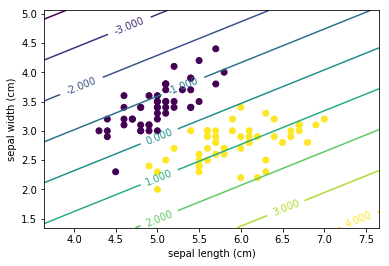

In [36]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);
plot_2d_separator(clf, X, levels=np.arange(-5, 5, 1))